In [1]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class RBFlayer(nn.Module):
    def __init__(self, timelag):
        super(RBFlayer, self).__init__()

        self.timelag = timelag
        torch.cuda.manual_seed(0)

        self.init_weight = nn.Parameter(torch.rand(self.timelag))
        self.rbf_clt = self.init_clt()
        self.rbf_std = self.init_std()
        

    def init_clt(self):
        return nn.Parameter(torch.rand(1))

    def init_std(self):
        return nn.Parameter(torch.rand(1))
    
    def rbf(self, x, cluster, std):
        return torch.exp(-(x - cluster) * (x - cluster) / 2 * (std * std))
    
    def rbf_gradient(self, x, clt, std): # again
        return (-1 * (x - clt) * (x - clt) / (std * std)) * (torch.exp(-(x - clt) * (x - clt) / 2 * (std * std)))
    
    
    ## sum 
    
    def forward(self, x):        
        for i in range(len(x)):
            if i == 0:
                a = self.rbf(x[i], self.rbf_clt, self.rbf_std)
            else:
                a = torch.cat([a, self.rbf(x[i], self.rbf_clt, self.rbf_std)], dim=0)
        cause = self.init_weight * a
        
        
        return cause

In [11]:
def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params
        
def train_RBFlayer(model, input_,target, lr, epochs, lookback = 5, device = device):
    model.to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    train_loss_list = []
    
    best_it = None
    best_model = None
    best_loss = np.inf
    target_list = []
    for j in range(len(target) - 2):
        target_list.append((target[j+2] - target[j])/2)
    
    loss_list = []
    cause_list = []
    for epoch in range(epochs):
        cause = model(input_)
        cause_list.append(cause)
        grad = []
        
        
        for i in range(len(cause) - 2):
            grad.append((cause[i+2] - cause[i])/2)
        
        loss1 = sum([loss_fn(grad[i], target_list[i]) for i in range(len(grad))])
        loss2 = sum([loss_fn(cause[i], target[i]) for i in range(len(input_))])
        
        loss = loss1 + loss2
        
        loss.backward()
        optimizer.step()
        model.zero_grad()
        
        loss_list.append(loss)
        mean_loss = loss / len(grad)
        train_loss_list.append(mean_loss)
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_it = epoch
            best_model = deepcopy(model)
            
        elif (epoch - best_it) == lookback:
            if verbose:
                print('Stopping early')
            break
    print("epoch {} cause loss {} :".format(epoch, loss / len(input_)))
    print('gradient loss :', loss1/len(grad))
    print('value loss :', loss2/len(input_))
                
    best_cause = cause_list[best_it]    
    restore_parameters(model, best_model)

    return best_model, loss_list, best_cause

In [4]:
def data_split(X, cause, target, timelag, device = device):
    input_cause = []
    input_target = []
    Y = []

    for i in range(len(X) - (timelag + 1)):
        input_cause.append(X[cause].values[i: i + timelag])
        input_target.append(X[target].values[i: i + timelag])
        Y.append([X[target][i + timelag + 1]])

    return torch.tensor(input_cause, device=device).float(), torch.tensor(input_target,device=device).float(), torch.tensor(Y, device=device).float()


In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('./road_gang.csv')

In [7]:
df

,1220029700,1220032100,1220033000,1220024600,1220028200,1220025300,1220029200,1220034000,1220034300,1220027500,...,1220026300,1220033400,1220025200,1220033100,1220031800,1220033300,1220031000,1220034600,1220032800,1220026800
0,25.19,29.65,28.08,25.14,20.30,28.74,31.59,32.78,27.48,22.42,...,31.11,31.87,25.61,35.04,36.00,31.82,25.18,24.80,17.00,29.09
1,26.96,24.27,26.63,26.65,20.49,26.28,28.80,30.56,26.95,26.38,...,30.26,34.42,26.18,34.95,36.61,30.24,25.07,21.33,26.80,28.95
2,26.20,28.07,27.76,24.94,22.35,27.88,32.74,32.22,35.34,24.03,...,33.27,24.70,24.06,31.08,37.30,27.94,24.16,30.84,24.68,31.14
3,26.72,23.98,26.34,27.54,24.68,29.85,27.55,28.83,31.98,24.20,...,32.80,30.08,26.93,35.77,34.74,27.34,25.15,27.20,24.02,33.40
4,27.21,24.11,26.63,24.71,19.57,26.93,29.77,30.60,28.39,23.18,...,30.48,26.82,26.36,32.22,38.51,28.47,23.82,30.69,23.19,33.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,25.93,30.45,24.45,33.18,15.57,20.59,30.61,29.28,23.61,30.60,...,19.85,25.20,27.80,31.92,30.67,24.67,29.33,27.84,25.39,19.88
2876,28.45,27.57,25.38,26.65,14.22,22.52,28.59,31.06,23.44,25.70,...,24.13,22.81,30.25,33.22,30.90,35.58,24.49,20.18,23.27,20.13
2877,25.24,27.17,25.96,30.91,14.31,22.32,33.68,27.55,24.82,30.14,...,22.21,23.94,30.70,37.34,36.29,26.00,27.74,24.46,27.52,21.00
2878,28.05,27.64,26.57,27.84,14.21,19.66,34.09,38.60,23.98,32.08,...,24.17,20.92,29.39,31.57,32.62,27.73,31.33,30.03,22.63,20.20


In [8]:
a = df[['1220029700','1220032100']]

In [9]:
import matplotlib.pyplot as plt

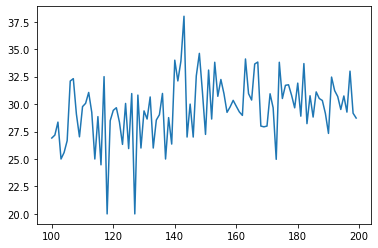

In [19]:
plt.plot(a['1220029700'][100:200])

In [9]:
X2d = df[['1220029700','1220032100']]
torch.manual_seed(1234)
input_cause, input_target, Y = data_split(X2d, '1220029700', '1220032100', 100)

In [18]:
input_cause1 = input_cause[:5]
input_cause2 = input_cause[100:130]

In [17]:
import time

cause_list = []
for i in range(len(input_cause1)):
    print(i,"번째 time series")
    start = time.time()
    model = RBFlayer(100)
    best_model, loss_list, best_cause = train_RBFlayer(model, input_cause1[i], 0.01, 1000, device)
    cause_list.append(best_cause.cpu().detach().numpy())
    print("time :", time.time() - start)
    print('-------------------------------------------------------------------------------------------')
    
import pickle

filePath = './gang_grad1_epcoh1000.txt'
with open(filePath, 'wb') as lf:
    pickle.dump(cause_list, lf)

0 번째 time series
epoch 999 cause loss 897.6409301757812 :
gradient loss : tensor(5.2817, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(892.4648, device='cuda:0', grad_fn=<DivBackward0>)
time : 126.11852669715881
-------------------------------------------------------------------------------------------
1 번째 time series
epoch 999 cause loss 898.5419311523438 :
gradient loss : tensor(5.2868, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(893.3608, device='cuda:0', grad_fn=<DivBackward0>)
time : 124.28551745414734
-------------------------------------------------------------------------------------------
2 번째 time series
epoch 999 cause loss 397.0220642089844 :
gradient loss : tensor(4.8400, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(392.2789, device='cuda:0', grad_fn=<DivBackward0>)
time : 125.76394867897034
-------------------------------------------------------------------------------------------
3 번째 time series
epoch 999 cause loss 899.8

In [19]:
target = input_cause1/5

In [17]:
import time

cause_list = []
for i in range(len(input_cause1)):
    print(i,"번째 time series")
    start = time.time()
    model = RBFlayer(100)
    best_model, loss_list, best_cause = train_RBFlayer(model, target[i],input_cause1[i], 0.01, 1000, device)
    cause_list.append(best_cause.cpu().detach().numpy())
    print("time :", time.time() - start)
    print('-------------------------------------------------------------------------------------------')
    
import pickle

filePath = './gang_scale_grad1_epcoh1000.txt'
with open(filePath, 'wb') as lf:
    pickle.dump(cause_list, lf)

0 번째 time series
epoch 999 cause loss 393.1730651855469 :
gradient loss : tensor(4.7079, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(388.5594, device='cuda:0', grad_fn=<DivBackward0>)
time : 121.4890387058258
-------------------------------------------------------------------------------------------
1 번째 time series
epoch 999 cause loss 412.5904235839844 :
gradient loss : tensor(4.7348, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(407.9503, device='cuda:0', grad_fn=<DivBackward0>)
time : 120.42959809303284
-------------------------------------------------------------------------------------------
2 번째 time series
epoch 999 cause loss 411.2395324707031 :
gradient loss : tensor(4.7801, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(406.5550, device='cuda:0', grad_fn=<DivBackward0>)
time : 121.28943657875061
-------------------------------------------------------------------------------------------
3 번째 time series
epoch 999 cause loss 395.31

KeyboardInterrupt: 

In [21]:
import time

cause_list = []
for i in range(len(input_cause1)):
    print(i,"번째 time series")
    start = time.time()
    model = RBFlayer(100)
    best_model, loss_list, best_cause = train_RBFlayer(model, target[i],input_cause1[i], 0.001, 1000, device)
    cause_list.append(best_cause.cpu().detach().numpy())
    print("time :", time.time() - start)
    print('-------------------------------------------------------------------------------------------')
    
import pickle

filePath = './gang_scale_grad1_epcoh1000.txt'
with open(filePath, 'wb') as lf:
    pickle.dump(cause_list, lf)

0 번째 time series
epoch 999 cause loss 779.6001586914062 :
gradient loss : tensor(5.1772, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(774.5265, device='cuda:0', grad_fn=<DivBackward0>)
time : 122.56511044502258
-------------------------------------------------------------------------------------------
1 번째 time series
epoch 999 cause loss 782.0703735351562 :
gradient loss : tensor(5.2912, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(776.8850, device='cuda:0', grad_fn=<DivBackward0>)
time : 122.61654448509216
-------------------------------------------------------------------------------------------
2 번째 time series
epoch 999 cause loss 776.5667724609375 :
gradient loss : tensor(5.0854, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(771.5831, device='cuda:0', grad_fn=<DivBackward0>)
time : 121.75101661682129
-------------------------------------------------------------------------------------------
3 번째 time series


KeyboardInterrupt: 